# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [24]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


ytrain check [6 9 9 ..., 9 1 1] 0
ytrain check [6 9 9 ..., 9 1 1] 1
ytrain check [6 9 9 ..., 9 1 1] 2
ytrain check [6 9 9 ..., 9 1 1] 3
ytrain check [6 9 9 ..., 9 1 1] 4
ytrain check [6 9 9 ..., 9 1 1] 5
ytrain check [6 9 9 ..., 9 1 1] 6
ytrain check [6 9 9 ..., 9 1 1] 7
ytrain check [6 9 9 ..., 9 1 1] 8
ytrain check [6 9 9 ..., 9 1 1] 9


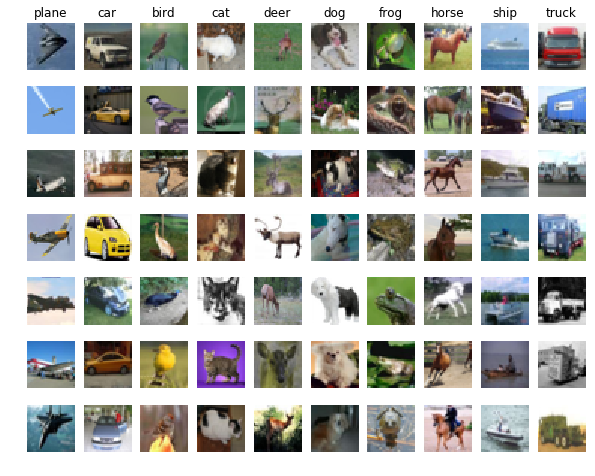

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    print "ytrain check",y_train ,y
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [26]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [27]:
# Reshape the image data into rows
print X_train.shape[0]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
print X_train
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

5000
[[  59.   62.   63. ...,  123.   92.   72.]
 [ 154.  177.  187. ...,  143.  133.  144.]
 [ 255.  255.  255. ...,   80.   86.   84.]
 ..., 
 [ 167.  163.  145. ...,   42.   78.   84.]
 [ 154.  152.  125. ...,  194.  247.  114.]
 [  45.   32.   21. ...,  156.  142.  100.]]
(5000, 3072) (500, 3072)


In [28]:
from classifiers.k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:

dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

500 5000
[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]
(500, 5000)


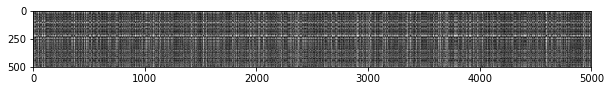

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')

**Inline Question #1:** Notice the structured patterns in the distance matrix. 

- What is the cause behind the distinctly visible rows? 
- What causes the columns?

**Your Answer**: *fill this in.*
default color scheme ->black -> low distance, white-> high distance
1)One distinctly bright row indicates that this testing image is not similar to a large number of training images in terms of L2 distance.

2)One distinguishable column implies that this training image is either similar to a lot of testing images (black column, low L2 distance) or not similar to a lot of training images (white column, high L2 distance).

In [13]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
print y_train[4601]
state = [8,3]
mask = np.in1d(y_train,state)
print np.where(mask)
print y_train[17]
# print y_train.
y_test_pred = classifier.predict_labels(dists, k=2)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

0
(array([   8,    9,   17, ..., 4988, 4994, 4995]),)
3
[ 420 3684 4224 ..., 4375 2744 4601]
[False False False ..., False False False]
closest_y [8, 3]
<type 'list'> <built-in method count of list object at 0x1139bcdd0>
[2192 4848 2166 ..., 4400 4688 1387]
[False False False ..., False False False]
closest_y [9, 7]
<type 'list'> <built-in method count of list object at 0x1139e0ef0>
[4469  909 3904 ..., 4921 3355 3837]
[False False False ..., False False False]
closest_y [2, 2]
<type 'list'> <built-in method count of list object at 0x123d692d8>
[ 252 4453 4270 ..., 4688 4921 1387]
[False False False ..., False False False]
closest_y [0, 8]
<type 'list'> <built-in method count of list object at 0x1139bcdd0>
[1881 3949 3797 ..., 4271 2744 4601]
[False False False ..., False False False]
closest_y [4, 8]
<type 'list'> <built-in method count of list object at 0x123e4cd88>
[2654  347 1983 ...,  790 4601 2744]
[False False False ..., False False False]
closest_y [0, 9]
<type 'list'> <built-i

In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

500 5000
[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]
Two loop version took 385.572062 seconds
One loop version took 373.968438 seconds
No loop version took 1.359446 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [29]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.split(X_train,indices_or_sections=num_folds)
y_train_folds = np.split(y_train,indices_or_sections=num_folds)
#l = X_train.tolist()
#print l[0],len(l[0])
#print X_train_folds[0][0]
#print np.nonzero(X_train == X_train_folds[0][0])
#print X_train[0] == X_train_folds[0][0]
#print X_train[0]

#X_train[]
#print l.index(X_train_folds[0][0])
#print np.where(X_train == X_train_folds[0][0])[0].shape
# y_i = l.index(X_train_folds[0][0]) # i will return index of 2
#print y_train_folds[2][0]
#print y_train[2000]
#assert y_train_folds[0][0] == y_train[0]
pass
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    accuracies = []
    for j in range(num_folds):
        # train the classifier using each X_train fold with k
        X_train_cv = np.vstack(X_train_folds[0:j]+ X_train_folds[j+1:])
        X_test_cv = X_train_folds[j]
        
        y_train_cv = np.hstack(y_train_folds[0:j]+ y_train_folds[j+1:])
        y_test_cv = y_train_folds[j]
        
        
        classifier.train(X_train_cv,y_train_cv)
        dist_cv = classifier.compute_distances_no_loops(X_test_cv)
        print dist_cv.shape
        print "some list"
        print dist_cv[0][0][0][0].shape
        y_test_pred = classifier.predict_labels(dist_cv,k)
        num_correct = np.sum(y_test_pred == y_test_cv)
        accuracy = float(num_correct) / len(y_test)
        print 'Got %d / %d correct => accuracy: %f %%' % (num_correct, num_test, accuracy*100.0)
        accuracies.append(accuracy)
    k_to_accuracies[k] = accuracies
# pass
# ################################################################################
# #                                 END OF YOUR CODE                             #
# ################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

(1000, 4000)
some list
(1, 4000)
Got 263 / 500 correct => accuracy: 52.600000 %
(1000, 4000)
some list
(1, 4000)
Got 257 / 500 correct => accuracy: 51.400000 %
(1000, 4000)
some list
(1, 4000)
Got 264 / 500 correct => accuracy: 52.800000 %
(1000, 4000)
some list
(1, 4000)
Got 278 / 500 correct => accuracy: 55.600000 %
(1000, 4000)
some list
(1, 4000)
Got 266 / 500 correct => accuracy: 53.200000 %
(1000, 4000)
some list
(1, 4000)
Got 241 / 500 correct => accuracy: 48.200000 %
(1000, 4000)
some list
(1, 4000)
Got 249 / 500 correct => accuracy: 49.800000 %
(1000, 4000)
some list
(1, 4000)
Got 243 / 500 correct => accuracy: 48.600000 %
(1000, 4000)
some list
(1, 4000)
Got 273 / 500 correct => accuracy: 54.600000 %
(1000, 4000)
some list
(1, 4000)
Got 264 / 500 correct => accuracy: 52.800000 %
(1000, 4000)
some list
(1, 4000)
Got 258 / 500 correct => accuracy: 51.600000 %
(1000, 4000)
some list
(1, 4000)
Got 273 / 500 correct => accuracy: 54.600000 %
(1000, 4000)
some list
(1, 4000)
Got 281

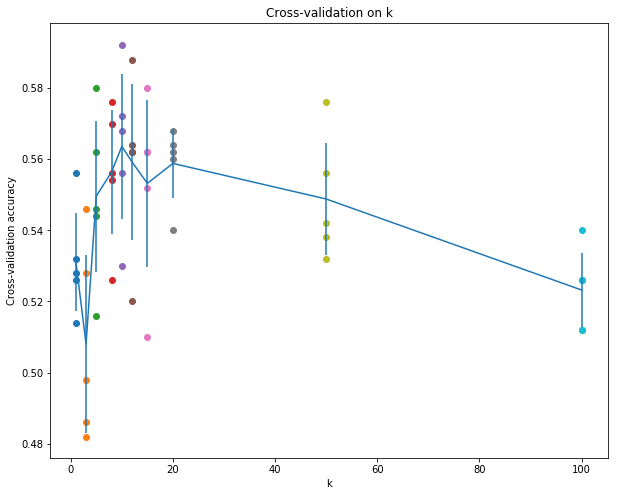

In [30]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [31]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k =10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000
